# Import Library

In [1]:
import zipfile
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import cv2


import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image

from PIL import Image
import keras.utils as image

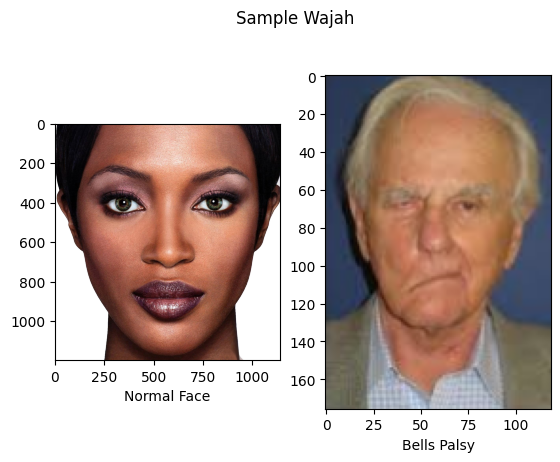

In [2]:
img_1 = Image.open("train/normal face/12.jpg")
img_2 = Image.open("train/bells_palsy/5.PNG")
plt.subplot(1, 2, 1)
plt.xlabel("Normal Face")
plt.imshow(img_1)

plt.subplot(1, 2, 2)
plt.xlabel("Bells Palsy")
plt.imshow(img_2)

plt.suptitle("Sample Wajah")
plt.show()

# Ekstraksi CirI Bentuk

In [3]:
# data = ['bells_palsy', 'normal face']
# type_data = ['train', 'validation']
# for i in type_data:
#     for j in data :
#         for k in os.listdir(f'{i}/{j}/'):
#             gambar = cv2.imread(f"{i}/{j}/{k}")
#             gray = cv2.cvtColor(gambar, cv2.COLOR_BGR2GRAY)
#             _, thres = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

#             kontur, _ = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#             for cnt in kontur:
#                 approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
#                 cv2.drawContours(gambar, [approx], 0, (0, 255, 0), 3)
            
#             if i == "train":
#                 cv2.imwrite(f"ekstraksi_train/{j}/{k}", gambar)
            
#             else:
#                 cv2.imwrite(f"ekstraksi_test/{j}/{k}", gambar)

# Augmentasi

In [4]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2)
 
validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2)

In [5]:
base_dir = "/"
train_dir = 'train'
validation_dir = 'Validation'

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(224, 224),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        classes=['bells_palsy', 'normal face'], # karena ini merupakan masalah klasifikasi 2 kelas, gunakan class_mode = 'binary'
        class_mode='binary')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(224, 224), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        classes=['bells_palsy', 'normal face'],# karena ini merupakan masalah klasifikasi lebih dari 2 kelas maka menggunakan class_mode = 'cattegorical'
        class_mode='binary')

Found 60 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [7]:
print(train_generator.class_indices)

{'bells_palsy': 0, 'normal face': 1}


# Membuat Model

In [20]:
model = tf.keras.models.Sequential()
#FEATURE EXTRACTION
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#FLATTEN
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                 

# Training Model

In [22]:
ACCURACY_THRESHOLD = 0.90
# Implement callback function to stop training
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.95
class myCallback(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
            
callbacks = myCallback()
model.fit(
      train_generator,
      steps_per_epoch=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=500, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks = [callbacks])

Epoch 1/500
5/5 - 2s - loss: 6.4777 - accuracy: 0.5000 - val_loss: 0.7072 - val_accuracy: 0.4500 - 2s/epoch - 478ms/step
Epoch 2/500
5/5 - 1s - loss: 0.7359 - accuracy: 0.4500 - val_loss: 0.6920 - val_accuracy: 0.5500 - 1s/epoch - 287ms/step
Epoch 3/500
5/5 - 1s - loss: 0.6977 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.6000 - 1s/epoch - 282ms/step
Epoch 4/500
5/5 - 2s - loss: 0.6932 - accuracy: 0.5500 - val_loss: 0.6926 - val_accuracy: 0.7500 - 2s/epoch - 310ms/step
Epoch 5/500
5/5 - 1s - loss: 0.6932 - accuracy: 0.4000 - val_loss: 0.6929 - val_accuracy: 0.8500 - 1s/epoch - 293ms/step
Epoch 6/500
5/5 - 1s - loss: 0.6935 - accuracy: 0.3500 - val_loss: 0.6930 - val_accuracy: 0.5500 - 1s/epoch - 283ms/step
Epoch 7/500
5/5 - 1s - loss: 0.6918 - accuracy: 0.6000 - val_loss: 0.6927 - val_accuracy: 0.5500 - 1s/epoch - 267ms/step
Epoch 8/500
5/5 - 1s - loss: 0.6995 - accuracy: 0.4500 - val_loss: 0.6928 - val_accuracy: 0.5000 - 1s/epoch - 267ms/step
Epoch 9/500
5/5 - 1s - loss: 0.6

# Uji Coba Model

In [23]:
def predict_image(path):
 
    # predicting images 
  img = keras.utils.load_img(path, target_size=(224,224))
  print("Shape image : {}".format(np.shape(img)))

  imgplot = plt.imshow(img)
  x = keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  predict_category = model.predict(images)
  return predict_category[0][0]



===== Data human Face
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 67ms/step
26.jpg === 1.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 26ms/step
261.jpg === 1.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 28ms/step
280.jpg === 1.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 37ms/step
569.jpg === 1.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 28ms/step
99.jpg === 0.9940028786659241
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 27ms/step
real_00015.jpg === 1.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 27ms/step
real_00107.jpg === 0.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 28ms/step
real_00387.jpg === 0.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 29ms/step
real_00391.jpg === 1.0
Shape image : (224, 224, 3)
1/1 [==============================] - 0s 28m

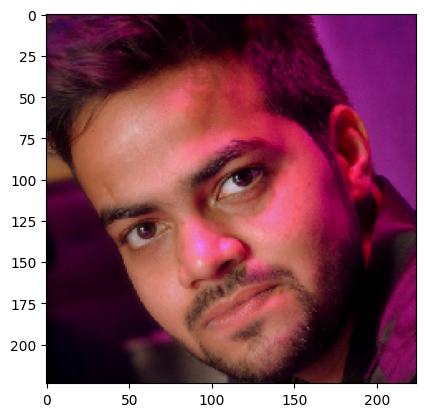

In [24]:
data_test_1 = os.listdir('./Validation/normal face/')
# data_test_2 = os.listdir('./Validation/normal face/')
result = []
print("===== Data human Face")
for i in data_test_1[:20]:
    data = predict_image(f'./Validation/normal face/{i}')
    result.append(data)
    print(f"{i} === {data}")

# print("===== Data Bells_palsy")
# for i in data_test_2:
#     predict_image(f'./Validation/bells_palsy/{i}')

In [25]:
data_bells = 0
data_normal = 0
for i in result:
    if int(i) > 0 :
        data_normal += 1
    else:
        data_bells += 1

print(f"Bells Palsy : {data_bells}\nNormal Face : {data_normal}")

Bells Palsy : 10
Normal Face : 10


In [ ]:
# data = predict_image('Picture1.png')
# print(data)

In [ ]:
# import shutil
# import os

# data_list = os.listdir('train/human face')
# path = 'train/human face/'
# for num, i in enumerate(data_list):
#     shutil.move(path + i, '{}{}.jpg'.format(path, num))

In [ ]:
model.save('model_01.h5')